In [117]:
'''
Resample stationary time series by using Stationary Bootstrap Method (Boris Radovanov and Aleksandra Marcikić)
and subsequently generate confidence bands.

Deepak Kumar Gouda
6 November, 2018
'''

'\nResample stationary time series by using Stationary Bootstrap Method (Boris Radovanov and Aleksandra Marcikić)\nand subsequently generate confidence bands.\n\nDeepak Kumar Gouda\n6 November, 2018\n'

In [118]:
import numpy as np
from numpy.random import randint, geometric
from math import factorial, sqrt
import matplotlib.pyplot as plt
from pandas import read_csv

In [119]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import TensorBoard, EarlyStopping

In [120]:
from time import time
import itertools

In [121]:
# Generate X and Y pairs where dim of X = (1, look_back)
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [122]:
# Arrange blocks of data according to permutation
def arrange_data(data, perm):
    arranged_data = []
    for i in perm:
        arranged_data.append(data[i])
    return arranged_data

In [123]:
def data_resample(data, blockSize, overlap = 0):
    n = len(data) # 100
    numBlocks = (n-overlap)//(blockSize-overlap) # 20
    resampled_data = []
    i = 0
    while (i+blockSize) <= len(data):
        x = data[i: (i+blockSize)]
        indx = randint(0, blockSize, size = blockSize)
        y = [x[j] for j in indx]
        resampled_data.append(y)
        i = i + blockSize - overlap
    return resampled_data

In [124]:
def block_resample(data, numBlocks, overlap = 0):
    I = randint(1, len(data), size=(numBlocks, 1))
    L = geometric(0.0027, size=(numBlocks, 1))
    resampled_data = []
    
    for i in range(numBlocks):
        if I[i]+L[i] < len(data):
            x = data[int(I[i]): int(I[i]+L[i])]
        else:
            x = data[int(I[i]):]
            x1 = data[: int(L[i]-(len(data)-I[i]))]
            x = x.reshape((len(x), 1))
            x1 = x1.reshape((len(x1), 1))
            np.vstack((x, x1))
        x = np.reshape(x, (len(x), 1))
        resampled_data.append(x)
#     print(len(resampled_data))
    return resampled_data

In [125]:
# block_resample(data, 3)

In [126]:
fields = ['open', 'close']
dataframe = read_csv('GOOGL_data.csv', skipinitialspace = True, squeeze = True, usecols = fields)

print(dataframe.head())
rawdata = np.array(dataframe)
print(rawdata.shape)

       open     close
0  390.4551  393.0777
1  389.5892  391.6012
2  391.2659  390.7403
3  390.4551  391.8214
4  390.2549  394.3039
(1259, 2)


In [127]:
data = rawdata[:,1] - rawdata[:,0]
# data = np.reshape(data, (len(data), 1))
data = data.reshape((len(data), 1))
# data = data.reshape((-1, 1))

In [128]:
# Scale between (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data[:5])

[[0.46061351]
 [0.4537273 ]
 [0.42510883]
 [0.44644525]
 [0.47670012]]


In [129]:
split = 0.72
trainSize = int(len(data)*split)
testSize = len(data)-trainSize
print(trainSize)
print(testSize)

906
353


In [130]:
train = data[0:trainSize,:]
test = data[trainSize:len(data),:]
rawtrain = rawdata[0:trainSize,:]
rawtest = rawdata[trainSize:len(data),:]
print(train[:5])

[[0.46061351]
 [0.4537273 ]
 [0.42510883]
 [0.44644525]
 [0.47670012]]


In [131]:
numBlocks = 3

In [132]:
randint(1, len(data), size=(len(data), 1))
geometric(0.0027, size=(numBlocks, 1))

array([[462],
       [  9],
       [214]])

In [133]:
A = np.array([[[1], [2], [3]], [[4], [5], [6]], [[7], [8], [9]]])
print(A[0].shape)
B = np.reshape(A, (A.shape[0]*A[0].shape[0], A[0].shape[1]))
B

(3, 1)


array([[1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [134]:
rawPrice = rawtest[:, 0]
rawPrice = np.reshape(rawPrice, (len(rawPrice), 1))
rawPrice = rawPrice[4:]

In [135]:
rawPrice.shape

(349, 1)

In [136]:
# Generate all permutations of the series 0, 1, 2, ... numBlocks
permutations = itertools.permutations(range(numBlocks))
testBand = []
count = 1
suffix = "B"

totalCount = factorial(numBlocks)
for perm in permutations:
    print("Count = %d/%d" % (count, totalCount))
    count += 1
    trainResample = block_resample(train, numBlocks)
#     print(len(trainResample))
    suffix = "B"
    trainSet = np.array(arrange_data(trainResample, perm))
#     print(trainSet[0].shape)
#     trainSet = np.reshape(trainSet, (trainSet.shape[0]*trainSet[0].shape[0], trainSet[0].shape[1]))
#     trainSet = np.reshape(trainSet, (trainSet.shape[0]*trainSet[0].shape[0], 1))
#     trainSet = np.reshape(trainSet, (trainSet.shape[0], 1))
#     print(trainSet.shape)
    flattenTrainSet = []
    for i in trainSet:
        for j in i:
            flattenTrainSet.append(j)
            
    trainSet = flattenTrainSet


# test.shape
    trainSet = np.reshape(trainSet, (len(trainSet), 1))

    shuffleData = np.vstack((trainSet, test))

    lookBack = 3
    trainX, trainY = create_dataset(trainSet, lookBack)
    testX, testY = create_dataset(test, lookBack)
#     print(trainX.shape)
#     print(trainY.shape)

#     trainX = np.reshape(trainX, (trainX.shape[0], 3, 1))
#     testX = np.reshape(testX, (testX.shape[0], 3, 1))

    units = 100
    drop = 0.0
    epoch = 5

#     model = load_model("./Models/StationaryBootstrap/"+str(numBlocks)+"_"+str(epoch)+"_"+str(100*drop)+"_"+suffix+".h5")
    
    model = Sequential()
    model.add(LSTM(units, input_shape=(lookBack, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='nadam')
#     Tensorboard
#     model.summary()
    tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
    model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=1, 
              callbacks=[EarlyStopping(monitor='loss', patience=2), tensorboard])
#     model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=1)

    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

#     Inverse the scaling
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)

#     RMSE score
    trainScore = sqrt(mean_squared_error(trainY, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = sqrt(mean_squared_error(testY, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))

#     Plot training data
#     trainPredictPlot = np.empty_like(shuffleData)
#     trainPredictPlot[:, :] = np.nan
#     trainPredictPlot[lookBack:len(trainPredict)+lookBack, :] = trainPredict
    
#     Plot test data
#     testPredictPlot = np.empty_like(shuffleData)
#     testPredictPlot[:, :] = np.nan
#     testPredictPlot[len(trainPredict)+(lookBack*2)+1:len(data)-1, :] = testPredict
    
#     Append results to calculate the test band
    testBand.append(testPredict+rawPrice)
#     plt.plot(scaler.inverse_transform(shuffleData)[:,col])
#     plt.plot(trainPredictPlot[:,col], color = 'orange')
#     plt.plot(testPredictPlot[:,col], color = 'green')

Count = 1/6
Epoch 1/5
763/763 [==============================] - 5s 7ms/step - loss: 0.0093
Epoch 2/5
763/763 [==============================] - 4s 6ms/step - loss: 0.0077
Epoch 3/5
763/763 [==============================] - 4s 6ms/step - loss: 0.0076
Epoch 4/5
763/763 [==============================] - 4s 6ms/step - loss: 0.0074
Epoch 5/5
763/763 [==============================] - 4s 5ms/step - loss: 0.0073
Train Score: 7.46 RMSE
Test Score: 8.43 RMSE
Count = 2/6
Epoch 1/5
912/912 [==============================] - 6s 6ms/step - loss: 0.0082
Epoch 2/5
912/912 [==============================] - 5s 6ms/step - loss: 0.0071
Epoch 3/5
912/912 [==============================] - 5s 6ms/step - loss: 0.0068
Epoch 4/5
912/912 [==============================] - 5s 6ms/step - loss: 0.0067
Epoch 5/5
912/912 [==============================] - 5s 6ms/step - loss: 0.0067
Train Score: 7.04 RMSE
Test Score: 8.39 RMSE
Count = 3/6
Epoch 1/5
963/963 [==============================] - 6s 6ms/step - loss: 0

In [137]:
model.save("./Models/StationaryBootstrap/"+str(numBlocks)+"_"+str(epoch)+"_"+str(100*drop)+"_"+suffix+".h5")

Text(0.5,1,'Epoch=5 numBlocks=3 Train=7.71 Test=8.64')

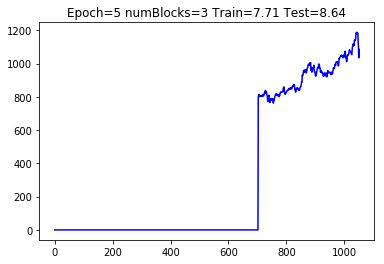

In [138]:
col = 0
testPlot = np.empty_like(trainSet)
testPlot[:, :] = 0

testPlot = np.vstack((testPlot, rawPrice))
testplot = scaler.inverse_transform(testPlot)
plt.plot(testPlot[:,col], color = 'blue')
plt.title('Epoch=%d numBlocks=%d Train=%.2f Test=%.2f' % (epoch, numBlocks, trainScore, testScore))

In [139]:
rawPrice+testPredict

array([[ 798.99723244],
       [ 799.43987442],
       [ 807.60761499],
       [ 813.13262166],
       [ 808.27178974],
       [ 800.45706101],
       [ 802.1896983 ],
       [ 804.86610721],
       [ 802.29473732],
       [ 801.23538785],
       [ 802.86576247],
       [ 803.99044967],
       [ 801.97628935],
       [ 803.72844022],
       [ 801.57622808],
       [ 811.99907295],
       [ 809.7502801 ],
       [ 804.77101607],
       [ 805.40237541],
       [ 803.93155145],
       [ 812.09710904],
       [ 822.34906771],
       [ 825.74606865],
       [ 818.70018101],
       [ 828.46010789],
       [ 836.23117638],
       [ 825.46625602],
       [ 821.49317301],
       [ 827.29533381],
       [ 819.81290644],
       [ 808.24706637],
       [ 803.70534397],
       [ 781.26298547],
       [ 768.40363936],
       [ 791.39454765],
       [ 799.66128185],
       [ 800.71027751],
       [ 808.96737146],
       [ 775.86013674],
       [ 769.96165443],
       [ 761.13075277],
       [ 767.137

In [140]:
testBand = np.array(testBand)
testBand = np.reshape(testBand, (testBand.shape))

In [141]:
testBand.shape

(6, 349, 1)

In [142]:
print(np.mean(testBand[:,0,:], axis = 0))
print(np.std(testBand[:,0,:], axis = 0))

[800.28280323]
[2.11609882]


In [143]:
z_alpha = 1.96
n = factorial(numBlocks)

confInterval = []

# Calculate the 95% confidence interval for each time step
for i in range(testBand.shape[1]):
    X = testBand[:, i, :]
    xBar = np.mean(X, axis = 0)
    s = np.std(X, axis = 0)
    l = xBar - 1.96*s/(n**0,.5)
    r = xBar + 1.96*s/(n**0,.5)
    pair = [l, r]
    confInterval.append(pair)

In [144]:
(scaler.inverse_transform(test)[:, col]).shape
# rawPrice.shape

(353,)

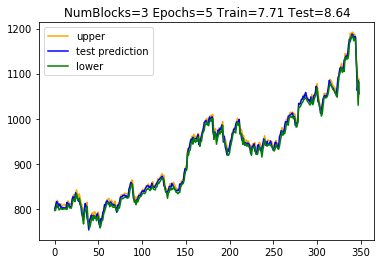

In [145]:
col = 0
offset = len(trainPredict)+(lookBack*2)+2
lower = []
upper = []

# Get upper and lower bounds
for i in range(len(confInterval)):
    lower.append(confInterval[i][0][0])
    upper.append(confInterval[i][1][0])

# XLower = np.array(range(offset+1, offset+1+testBand.shape[1]))
# XUpper = np.array(range(offset+1, offset+1+testBand.shape[1]))
# plt.plot(XLower, lower)
# plt.plot(XUpper, upper)
plt.plot(upper, color='orange', label='upper')
plt.plot(rawPrice+scaler.inverse_transform(test)[4:], color = 'blue', label='test prediction')
plt.plot(lower, color='green', label='lower')
plt.legend(loc='upper left')
plt.title('NumBlocks=%d Epochs=%d Train=%.2f Test=%.2f' % (numBlocks, epoch, trainScore, testScore))
plt.savefig("./Plots/StationaryBootstrap/"+str(numBlocks)+"_"+"_"+str(epoch)+"_"+str(100*drop)+"_"+suffix+".png")
plt.show()

In [146]:
# Sum of the lengths of the confidence intervals at each time point.
sumIntervals = np.sum(abs(np.array(upper) - np.array(lower)))

In [147]:
sumIntervals

3059.642150378673

In [148]:
# Length of maximum interval
maxInterval = np.max(np.array(upper) - np.array(lower))

In [149]:
maxInterval

10.931904758822839